In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import barbershop
from tqdm import tqdm

In [2]:
sfile = 'file2.txt'
df = pd.read_csv(sfile, sep='\s+')
df.head(5)
print(df.columns)
df['dist'] = 10.0**(df['m-M0'] / 5.0 + 1.0)
df['par'] = 1000.0/df.dist #parallax in mas
df['BV'] = df.B - df.V

Index([u'#Gc', u'logAge', u'[M/H]', u'm_ini', u'logL', u'logTe', u'logg',
       u'm-M0', u'Av', u'm2/m1', u'mbol', u'U', u'B', u'V', u'R', u'I', u'J',
       u'H', u'K', u'Mact'],
      dtype='object')


/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#Make some cuts
df = df.loc[np.abs(df.BV - 0.9) < 0.6]
df = df.loc[df.K > 8.0]
df = df.loc[df.logg < 3.5]

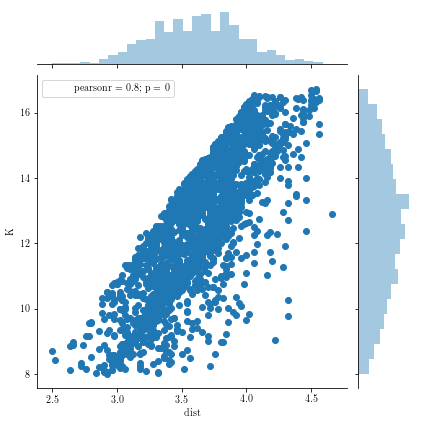

In [4]:
sns.jointplot(np.log10(df.dist), df.K)

In [5]:
#Calculate absolute magnitude (no extinction)
df['MK'] = df.K - 5.0 * np.log10(df.dist) + 5.0

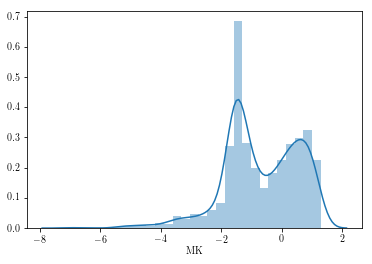

In [6]:
#Plot absolute magnitude in K
sns.distplot(df.MK)

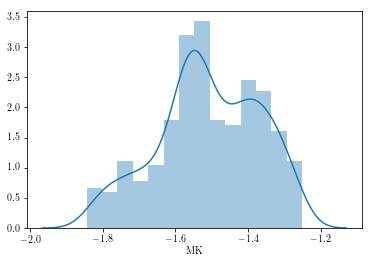

In [7]:
#Cut anything not directly around the clump
df = df.loc[np.abs(df.MK + 1.55) < 0.3]
sns.distplot(df.MK)

In [8]:
#Write the pystan model
import pystan
code = '''
data {
    int<lower = 0> N;
    real M_obs[N];
    real M_unc[N];
}
parameters {
    real M_std[N];
    real mu;
    real<lower = 0> sigma;
    real<lower = 0, upper = 1> fout;
    real<lower = 0> sout;
}
transformed parameters{
    real M_true[N];
    for (i in 1:N)
        M_true[i] = M_std[i] * sigma + mu;
}
model{
    M_std ~ normal(0, 1);
    M_obs ~ normal(M_true, M_unc);
    mu ~ normal(-1.54, 0.1);
    sigma ~ normal(0.04, 0.0001);
    for (n in 1:N)
       target += log_mix(fout,
                     normal_lpdf(M_true[n] | mu, sigma),
                     normal_lpdf(M_true[n] | mu, sout));
    sout ~ normal(1.5, 0.5);
    fout ~ normal(0.5, 0.01);
}

'''
sm = pystan.StanModel(model_code=code, model_name='ClumpModel')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL ClumpModel_7849108c2fcd7533479e5f3449008b6a NOW.


In [9]:
err = np.ones(len(df)) * 0.01
MK = df.MK + np.random.randn(len(df))*err
dat = {'N': len(MK),
      'M_obs': MK,
      'M_unc': err}
fit = sm.sampling(data=dat, iter=5000, chains=1)

/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


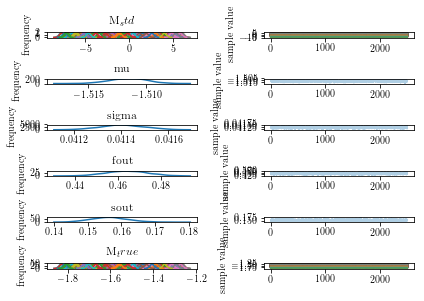

In [10]:
fit.plot()
plt.tight_layout()
plt.show()

In [11]:
print(fit)

Inference for Stan model: ClumpModel_7849108c2fcd7533479e5f3449008b6a.
1 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=2500.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
M_std[0]     -3.86  4.8e-3   0.24  -4.33  -4.03  -3.85   -3.7  -3.38 2500.0    1.0
M_std[1]     -3.09  4.8e-3   0.24  -3.55  -3.24  -3.09  -2.93  -2.62 2500.0    1.0
M_std[2]      2.77  4.9e-3   0.24   2.29    2.6   2.77   2.93   3.24 2500.0    1.0
M_std[3]      5.13  4.8e-3   0.24   4.67   4.97   5.13    5.3   5.59 2500.0    1.0
M_std[4]       3.4  5.0e-3   0.25   2.91   3.23    3.4   3.56   3.87 2500.0    1.0
M_std[5]     -0.74  4.9e-3   0.24  -1.23  -0.91  -0.74  -0.58  -0.26 2500.0    1.0
M_std[6]      0.46  4.6e-3   0.23 3.7e-3   0.31   0.46   0.62   0.92 2500.0    1.0
M_std[7]     -1.74  4.8e-3   0.24  -2.21  -1.91  -1.74  -1.57  -1.28 2500.0    1.0
M_std[8]      1.76  4.8e-3   0.24   1.29   1.59   1.76   1.93   

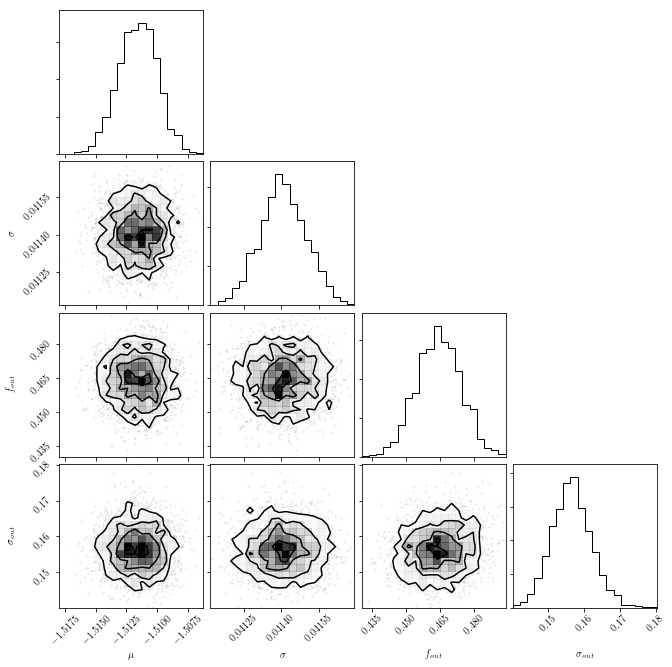

(2500, 633)

In [34]:
trace=fit.extract()
import corner
chain = np.array([trace['mu'],trace['sigma'],trace['fout'],trace['sout']])
corner.corner(chain.T,\
            labels=[r'$\mu$',r'$\sigma$',r'$f_{out}$',r'$\sigma_{out}$'])
plt.show()

trace['M_true'].shape

In [32]:
def N(x, mu, sigma):
    N = (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2 / (2*sigma**2))
    return N

In [42]:
'''NOTE: TECHNICALLY THIS SHOULD USE M_TRUE, NOT M_K. NOT SURE HOW TO IMPLEMENT THAT YET...'''
norm = 0.0
#Margnialize for the values of theta
for idx in tqdm(range(chain.shape[1])):
    fg = trace['fout'][idx] * N(MK, trace['mu'][idx], trace['sigma'][idx])
    bg = (1 - trace['fout'][idx]) * N(MK, trace['mu'][idx], trace['sout'][idx])
    fg_pp = fg / (fg + bg)
    bg_pp = bg / (fg + bg)
    norm += 1
    
#Normalize
bg_pp /= norm
fg_pp /= norm

100%|██████████| 2500/2500 [00:02<00:00, 939.61it/s]


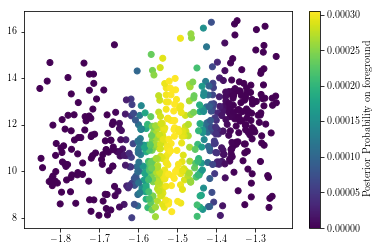

In [47]:
#Now lets plot MK against K coloured
fig, ax = plt.subplots()
c = ax.scatter(MK, df.K, c=fg_pp)
fig.colorbar(c,label='Posterior Probability on foreground')
plt.show()